## Imports

In [14]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# using Piccolo
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
# using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories

In [32]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3

0.005

In [29]:
Qs
seeds

30-element Vector{Int64}:
  86
 556
 526
 281
 414
 526
 606
 241
 317
 384
   ⋮
 376
 433
 875
 205
 269
 618
 836
 322
 119

In [33]:
# Adjoint, rollout initialization

∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)
var_probs = Matrix{Any}(undef, n_seeds, nQ)
tog_probs = Matrix{Any}(undef, n_seeds, nQ)

var_count = length(varsys_add.G_vars)

for (i, seed) in enumerate(seeds)
    Random.seed!(seed)
    for (j, Q) in enumerate(Qs)
        tog_prob = UnitaryToggleProblem(
            varsys_add, U_goal, T, Δt;
            a_bound=a_bound, 
            dda_bound=dda_bound,
            Δt_max=Δt,
            Δt_min=Δt,
            fast=false,
            Q=0.0,
            Q_t = Q,
            R=R,
            piccolo_options = PiccoloOptions(verbose=false)
        )
        push!(
            tog_prob.constraints, 
            FinalUnitaryFidelityConstraint(U_goal, :Ũ⃗, F, tog_prob.trajectory)
        );
        solve!(tog_prob, max_iter=num_iter, print_level=5, options=IpoptOptions(eval_hessian=false))
        tog_probs[i,j] = tog_prob
    end
end

In [4]:
var_prob[1].trajectory.Δt[1], var_prob[1].trajectory.Δt[end ÷ 2]

UndefVarError: UndefVarError: `var_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [34]:
∂ₑH = [PAULIS.Z]
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.Z]

function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}}
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    U = iso_vec_to_operator(Ũ⃗[:, end])
    # First error term
    ∂U = iso_vec_to_operator(∂Ũ⃗[1][:, end])

    d = size(U, 1)
    return abs(tr((U'*∂U)'*(U'*∂U))) / (T * Δt)^2 / d
end

# J_var = var_obj(var_prob.trajectory, H_drives, error_ops)

var_obj (generic function with 1 method)

In [35]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64}
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))
    
    # Toggle integral
    H_ti = sum(Δt[i] .* U[i]' * H_error * U[i] for i=1:T-1)

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end


tog_obj (generic function with 1 method)

In [14]:
J_tog / J_var

8.546746224338484

In [36]:
function commutator(A::AbstractMatrix{<:Number}, B::AbstractMatrix{<:Number})
    return A*B - B*A
end

commutator (generic function with 1 method)

In [37]:
function pert_tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    order::Int=1,
    a_bound::Float64=a_bound
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))

    # toggle integral
    H_ti = zeros(ComplexF64, size(U[1]))

    # note: U_1 = I, so U[:, k] = U_{k-1}.
    # you need to go to T-1, only
    for k in 1:T-1
        Hₖ = sum(traj.a[l, k] / a_bound * H for (l, H) in enumerate(H_drives))
        adjⁿH_E = H_error
        Eₖ_n = H_error * Δt[k]
        
        # get the different orders of the Hadamard lemma
        for n in 2:order
            coef_n = ComplexF64(im^(n-1) * a_bound^(n-1) * Δt[k]^n / factorial(big(n)))
            adjⁿH_E = commutator(Hₖ, adjⁿH_E)
            # Eₖ_n = push!(Eₖ_n, coef_n * adjⁿH_E)
            Eₖ_n += coef_n * adjⁿH_E
        end

        # nth order toggle integral up to k
        H_ti += U[k]' * Eₖ_n * U[k]
    end

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

pert_tog_obj (generic function with 1 method)

In [17]:
pert_tog_obj(var_prob.trajectory, H_drives, PAULIS.Z, order=1)

0.00033492546876706046

In [18]:
pert_tog_obj(var_prob.trajectory, H_drives, PAULIS.Z, order=5)

3.9187303149719265e-5

In [38]:
error_ops = [GATES.Z]
tog_objs = []
tog_vars = []
tog_pert = []

for (j, Q) in enumerate(Qs)
    Z_vec = vec(tog_probs[j].trajectory)
    push!(tog_objs, mean(tog_obj(tog_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds))
    push!(tog_vars, mean(var_obj(tog_probs[i,j].trajectory, H_drives, error_ops)  for i in 1:n_seeds))
    push!(tog_pert, mean(pert_tog_obj(tog_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2)  for i in 1:n_seeds))
end

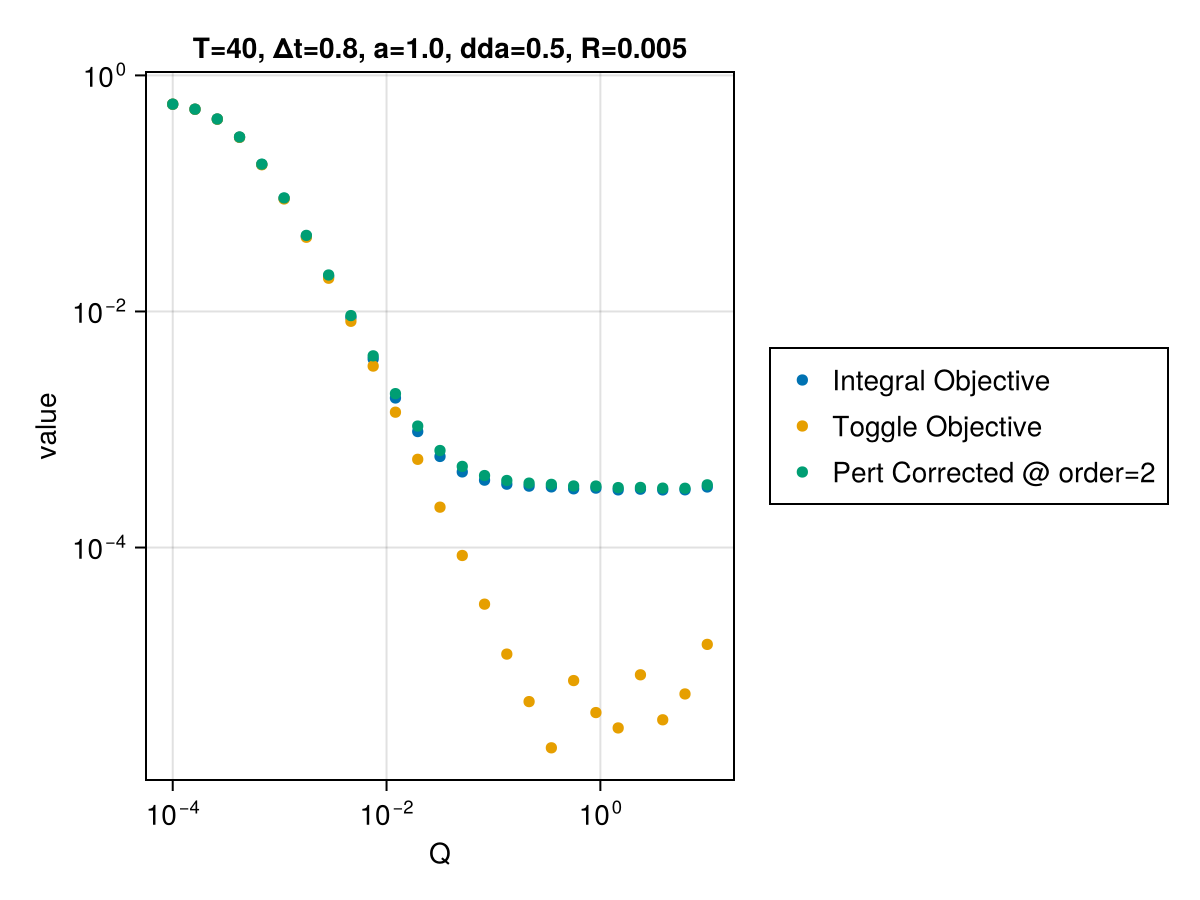

In [39]:
# T = var_probs[1].trajectory.T
# Δt = var_probs[1].trajectory.Δt[1]
# hessians off
fig = Figure()
ax = Axis(fig[1, 1], title="T=$T, Δt=$Δt, a=$a_bound, dda=$dda_bound, R=$R",xlabel="Q", ylabel="value",xscale=log10, yscale=log10)

scatter!(ax, Qs, tog_vars; label="Integral Objective", markersize=8)
scatter!(ax, Qs, tog_objs; label="Toggle Objective", markersize=8)
scatter!(ax, Qs, tog_pert; label="Pert Corrected @ order=2", markersize=8)

# errorbars!(ax, Qs, tog_vars, error_vars; whiskerwidth=10)
# errorbars!(ax, Qs, tog_objs, error_objs; whiskerwidth=10)
# errorbars!(ax, Qs, tog_pert, error_pert; whiskerwidth=10)

Legend(fig[1,2], ax)

fig

In [40]:
htog_probs = Matrix{Any}(undef, n_seeds, nQ)

for (i, seed) in enumerate(seeds)
    Random.seed!(seed)
    for (j, Q) in enumerate(Qs)
        tog_prob = tog_probs[i,j]
        solve!(tog_prob, max_iter=hess_iter, print_level=0)
        htog_probs[i,j] = tog_prob
    end
end

error_ops = [GATES.Z]
htog_objs = []
htog_vars = []
htog_pert = []

for (j, Q) in enumerate(Qs)
    Z_vec = vec(tog_probs[j].trajectory)
    push!(htog_objs, mean(tog_obj(htog_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds))
    push!(htog_vars, mean(var_obj(htog_probs[i,j].trajectory, H_drives, error_ops)  for i in 1:n_seeds))
    push!(htog_pert, mean(pert_tog_obj(htog_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2)  for i in 1:n_seeds))
end


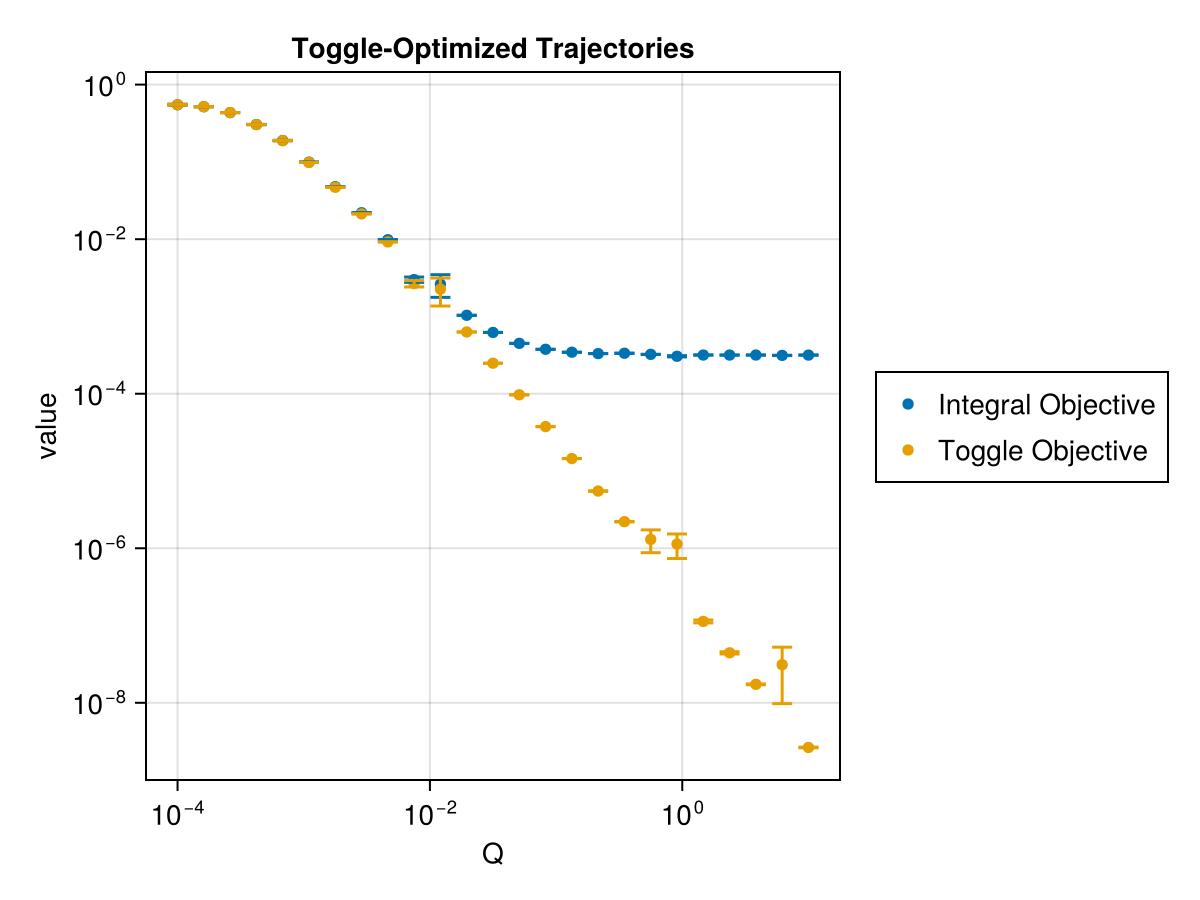

In [46]:
# T = var_probs[1].trajectory.T
# Δt = var_probs[1].trajectory.Δt[1]
# hessians on
# Initialize arrays for means and errors
tog_objs = []
tog_vars = []
tog_pert = []

tog_objs_std = []
tog_vars_std = []
tog_pert_std = []

tog_objs_sem = []  # Standard error of the mean
tog_vars_sem = []
tog_pert_sem = []

for (j, Q) in enumerate(Qs)
    # Collect all values for this Q across seeds
    objs_at_Q = [tog_obj(htog_probs[i,j].trajectory, H_drives, error_ops[1]) for i in 1:n_seeds]
    vars_at_Q = [var_obj(htog_probs[i,j].trajectory, H_drives, error_ops) for i in 1:n_seeds]
    pert_at_Q = [pert_tog_obj(htog_probs[i,j].trajectory, H_drives, PAULIS.Z, order=2) for i in 1:n_seeds]
    
    # Compute means
    push!(tog_objs, mean(objs_at_Q))
    push!(tog_vars, mean(vars_at_Q))
    push!(tog_pert, mean(pert_at_Q))
    
    # Compute standard deviations
    push!(tog_objs_std, std(objs_at_Q))
    push!(tog_vars_std, std(vars_at_Q))
    push!(tog_pert_std, std(pert_at_Q))
    
    # Compute standard error of the mean (std / sqrt(n))
    push!(tog_objs_sem, std(objs_at_Q) / sqrt(n_seeds))
    push!(tog_vars_sem, std(vars_at_Q) / sqrt(n_seeds))
    push!(tog_pert_sem, std(pert_at_Q) / sqrt(n_seeds))
end

# Plot with error bars (using standard error) #T=$T, Δt=$Δt, a=$a_bound, dda=$dda_bound, R=$R
fig = Figure()
ax = Axis(fig[1, 1], title="Toggle-Optimized Performance Separation",
          xlabel="Q (Weight on Toggle Cost Function)", ylabel="Objective Value", xscale=log10, yscale=log10)

scatter!(ax, Qs, tog_vars; label="Integral Objective", markersize=8)
scatter!(ax, Qs, tog_objs; label="Toggle Objective", markersize=8)
# scatter!(ax, Qs, tog_pert; label="Pert Corrected @ order=2", markersize=8)

errorbars!(ax, Qs, tog_vars, tog_vars_sem; whiskerwidth=10)
errorbars!(ax, Qs, tog_objs, tog_objs_sem; whiskerwidth=10)
# errorbars!(ax, Qs, tog_pert, tog_pert_sem; whiskerwidth=10)

Legend(fig[1,2], ax)

fig

In [42]:
using JLD2, FileIO

# Create the directory
artifacts_dir = "artifacts/tog_gap_data"
mkpath(artifacts_dir)

# Save the htog_probs data and parameters
save(joinpath(artifacts_dir, "htog_probs.jld2"), Dict(
    "htog_probs" => htog_probs,
    "seeds" => seeds,
    "Qs" => Qs,
    "F" => F,
    "num_iter" => num_iter,
    "hess_iter" => hess_iter,
    "a_bound" => a_bound,
    "dda_bound" => dda_bound,
    "R" => R
))

# Save the figure
save(joinpath(artifacts_dir, "plot.png"), fig)

println("Data saved to $artifacts_dir")


In [45]:
using JLD2, FileIO

# Create the directory
artifacts_dir = "artifacts/tog_gap_data_export"
mkpath(artifacts_dir)

# Save htog_probs data for each seed in separate files
for (i, seed) in enumerate(seeds)
    save(joinpath(artifacts_dir, "htog_probs_seed_idx_$(i).jld2"), Dict(
        "htog_probs" => htog_probs[i, :],
        "seed" => seed,
        "Qs" => Qs,
        "F" => F,
        "num_iter" => num_iter,
        "hess_iter" => hess_iter,
        "a_bound" => a_bound,
        "dda_bound" => dda_bound,
        "R" => R
    ))
end

# Save the figure
save(joinpath(artifacts_dir, "plot.png"), fig)

println("Data saved to $artifacts_dir")
println("Created $(length(seeds)) separate files, one for each seed")